# RUNTIME WARNING
Executing this notebook can take aprox. 10min because our generator is highly inefficent.

# Exercise 11
## Simulation chain for neutrino detector

In [1]:
# importing extensions
import numpy as np
import pandas as pd
import sympy as smp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from project_a2.random import Generator

smp.init_printing()

### a) Signal MC
Flow of neutrinos given by:

\begin{equation}
    \Phi(E) = \Phi_0 \cdot \left(\frac{E}{\text{TeV}}\right)^{-\gamma}
\end{equation}

Determining normalization constant $\Phi_0$:

The normalization constant has to be:


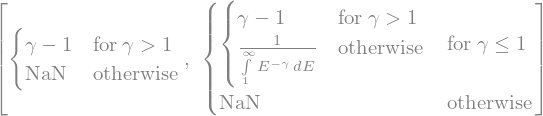

In [2]:
# calculating normalization constant phi_0
E, phi_0, phi, gamma = smp.symbols('E, phi_0, phi, gamma', real = True, positive = True)
f = phi_0*E**(-gamma)
f_int = smp.integrate(phi_0*E**(-gamma),(E, 1, smp.oo))
phi_0 = smp.solve(f_int-1, phi_0)

print(f'The normalization constant has to be:')
phi_0

As $\gamma = 2,7 > 1$,
\begin{equation}
    \Phi(E) = (\gamma-1) \cdot \left(\frac{E}{\text{TeV}}\right)^{-\gamma}
\end{equation}

Then, $u$ is given by
\begin{align}
   u &= \int_1^E \Phi(E') \text{d}E' \\
     &= \int_1^E (\gamma-1) \cdot \left(\frac{E'}{\text{TeV}}\right)^{-\gamma}\text{d}E'
\end{align}

u equals:


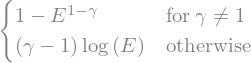

In [3]:
# calculating u
u = smp.integrate((gamma-1)*E**(-gamma), (E,1,E))
print(f'u equals:')
smp.simplify(u)

With the normalization constant $\Phi_0$ $u$ can be written as
\begin{align}
   u = 1-E^{1-\gamma}.
\end{align}

The energy $E$ is the inverse of $u$ and therefore
\begin{align}
   E = \left(1-u\right)^{\frac{1}{1-\gamma}}
\end{align}
with a normal distributed $u\in[0,1]$

In [4]:
# random generator, getting 10^5 u in [0,1]
rng = np.random.default_rng(666)

u = rng.uniform(size=10**5)

# defining function E
gamma = 2.7
def E(u):
    return (1-u)**(1/(1-gamma))

signal = pd.DataFrame({
    'Energy': E(u)
    
})

signal.head()

,Energy
0,2.339111
1,1.600574
2,1.583425
3,1.750415
4,1.278816


### b) Acceptance
The probability of detecting an event is engergy dependent with the probability
\begin{align}
   P(E)=\left(1-\text{e}^{-\frac{E}{2}}\right)^3.
\end{align}

In [5]:
# defining probability function
def P(E):
    return (1-np.e**(-E/2))**3

# Neumann rejection method
mask = np.zeros(10**5, dtype=bool)

for i in range(10**5):
    u2 = rng.uniform()
    if(P(signal['Energy'][i])<=u2):
        mask[i] = False
    else:
        mask[i] = True

signal['AcceptanceMask'] = mask

signal.head()

,Energy,AcceptanceMask
0,2.339111,True
1,1.600574,False
2,1.583425,False
3,1.750415,False
4,1.278816,True


Text(0.5, 1.0, 'Task a)')

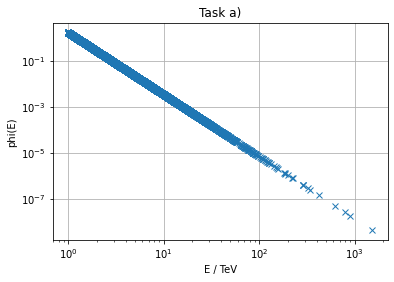

In [6]:
# plot for a)
def function_phi(E):
    return (gamma-1)*E**(-gamma)
plt.plot(signal['Energy'],function_phi(signal['Energy']), 'x')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('E / TeV')
plt.ylabel('phi(E)')
plt.grid()
plt.title('Task a)')

Text(0.5, 1.0, 'Task b)')

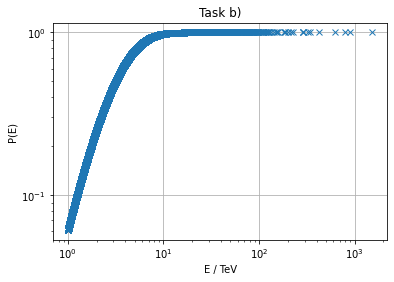

In [7]:
# plot for b)
plt.plot(signal['Energy'], P(signal['Energy']), 'x')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('E / TeV')
plt.ylabel('P(E)')
plt.grid()
plt.title('Task b)')

### c) Polar method

In [8]:
    def standard_normal(self, size=None):
        '''
        Override standard normal with using the Marsaglia polar method

        Blatt 5, Aufgabe 11b)
        '''
        # Fügen Sie hier den Code ein um Zufallszahlen aus der
        # angegebenen Verteilung zu erzeugen

        # dummy, so the code works. Can be removed / replaced
        # values = np.zeros(size)
        if size == None:
            size = 1
        
        x1 = np.zeros(size)
        x2 = np.zeros(size)
        
        for i in range(size):
            s = 2.
            v1 = 0.
            v2 = 0.
            while s > 1:
                u1 = self.uniform()
                u2 = self.uniform()
                v1 = 2*u1-1
                v2 = 2*u2-1
                s = v1**2+v2**2
            
            x1[i] = v1*np.sqrt(-2/s*np.log(s))
            x2[i] = v2*np.sqrt(-2/s*np.log(s))
                
        values = x1
        return values

    def normal(self, loc=0, scale=1, size=None):
        '''
        Scale and shift standard normal values

        Blatt 5, Aufgabe 11b)
        '''
        # Fügen Sie hier den Code ein um Zufallszahlen aus der
        # angegebenen Verteilung zu erzeugen

        # dummy, so the code works. Can be removed / replaced
        values = Generator.standard_normal(self, size=size)
        values = scale * values + loc
        return values

### d) Energy measurement

In [9]:
gen = Generator(seed=0)

hits = np.zeros(10**5)

for i in range(10**5):
    temp = -1
    while temp < 0:
        temp = gen.normal(loc=10*signal['Energy'][i], scale=2*signal['Energy'][i])
    temp = np.around(temp)
    hits[i] = temp
signal['NumberOfHits'] = hits
signal.head()

,Energy,AcceptanceMask,NumberOfHits
0,2.339111,True,27.0
1,1.600574,False,18.0
2,1.583425,False,16.0
3,1.750415,False,19.0
4,1.278816,True,16.0


### e) Spacial measurement

In [10]:
def sigma(N):
    return 1/(np.log10(N+1))

x = np.zeros(10**5)
y = np.zeros(10**5)

for i in range(10**5):
    x[i] = -1
    while x[i] < 0 or x[i] > 10:
        x[i] = gen.normal(loc=7, scale=sigma(signal['NumberOfHits'][i]))
    y[i] = -1
    while y[i] < 0 or y[i] > 10:
        y[i] = gen.normal(loc=3, scale=sigma(signal['NumberOfHits'][i]))
    
signal['x'] = x
signal['y'] = y
signal.head()
signal.to_hdf('NeutrinoMC.hdf5', 'key')

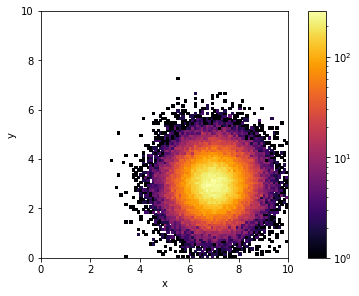

In [11]:
# 2d histogram
fig, ax = plt.subplots(constrained_layout=True)

ax.set_aspect('equal')

hist, xbins, ybins, plot = ax.hist2d(
    signal['x'],
    signal['y'],
    bins=[100, 100],
    range=[[0, 10], [0, 10]],
    norm=LogNorm(),
    cmap='inferno',
)
ax.set_xlabel('x')
ax.set_ylabel('y')

fig.colorbar(plot, ax=ax)

### f) Underground MC

In [12]:
# log_10 number of hits
log10noh = gen.normal(loc=2, scale=3, size = 10**7)

In [13]:
p = 0.5
mu = 5
sigma = 3

noh = 10**log10noh
noh = np.around(noh)

x = np.zeros(10**7)
y = np.zeros(10**7)

for i in range(10**7):
    x[i] = -1
    y[i] = -1
    while x[i] < 0 or x[i] > 10 or y[i] < 0 or y[i] > 10:
        x_star = gen.standard_normal()
        y_star = gen.standard_normal()
        x[i] = np.sqrt(1-p**2)*sigma*x_star+p*sigma*y_star+mu
        y[i] = sigma*y_star + mu

signalMC = pd.DataFrame({
    'NumberOfHits': noh,
    'x': x,
    'y': y
})
signalMC.head()
signalMC.to_hdf('UndergroundMC.hdf5', 'key')

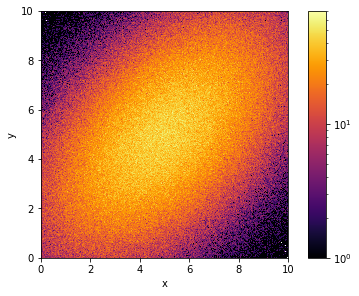

In [17]:
# 2d histogram
fig, ax = plt.subplots(constrained_layout=True)

ax.set_aspect('equal')

hist, xbins, ybins, plot = ax.hist2d(
    signalMC['x'],
    signalMC['y'],
    bins=[750, 750],
    range=[[0, 10], [0, 10]],
    norm=LogNorm(),
    cmap='inferno',
)
ax.set_xlabel('x')
ax.set_ylabel('y')

fig.colorbar(plot, ax=ax)

Text(0.5, 0, 'Hits')

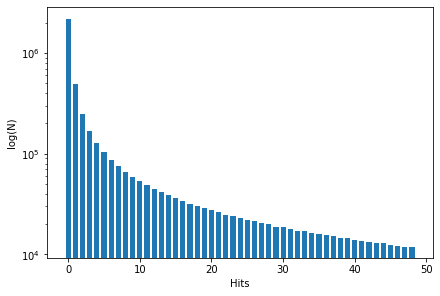

In [33]:
# 1d histogram
plt.figure(constrained_layout=True)

plt.hist(
    noh,
    bins=np.arange(50) - 0.5, 
    edgecolor='w',
    lw=2
)
plt.yscale('log')
plt.ylabel('log(N)')
plt.xlabel('Hits')